# Flat processing example

This is an example of how to use the program phifdt_flat.py

There are 5 steps:

1. Find the off-point data
2. Preprocess the off-point data
3. Run the main flat generation routine
4. Display and store the results

Look into :py:meth:`phifdt_pipe` for getting information about usage and options.

In [1]:
# Loading libraries

import sys
sys.path.append('../../../../sophi_fdt_dpp/')  
import sophi_fdt_dpp as fdt
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pyfits

### Finding data and checking them

For reading the data use: :py:meth:`fits_get()`

In [2]:
directory = 'test_data/'
files = sorted(fdt.list_fits(directory,contain = 'fdt-ilamc'))
print('There are',len(files),'flat files [shall be 9]')
print(iter(files),files[0])

dark_path = 'test_data/'
dark_file = f'{dark_path}solo_L1_phi-hrt-dark_20210428T130238_V202207012038C_0164281001.fits.gz'

prefilter_path = 'test_data/'
prefilter_file = f'{prefilter_path}0000990710_noMeta.fits'


There are 9 flat files [shall be 9]
<list_iterator object at 0x7ff3ff4dfa10> test_data//solo_L1_phi-fdt-ilamc_20210913T060003_V202111172120C_0169130100.fits


### Pre-processing the off-point data

In this case we will just correct the dark, the prefilter and the ghost. Further corrections can be applied (e.g., distortion).

In [ ]:
#only dark current
for i in files:
    fdt.fdt_flat_preprocessing(i, dark_file, verbose = False,correct_ghost = True,correct_prefilter = True,
        prefilter_fits = prefilter_file, version = '01')

The pre-processing removes the dark, the prefilter and, in first order, the ghost of all 24x9 images.

For instance, the dark correction:

<img src="figures/dark_correction.png">

While the prefilter correction, as seen in a random Stokes I profile of the data:

<img src="figures/prefilter_correction.png">

Finally, the ghost, in one of the processed images would look like:

<img src="figures/Ghost_correction.png">



### Run the main flat generation routine

Now, to calculate the 24 flats, the program :py:meth:`fdt_flat` has to be run over the 24 x 9 images. This can be done simply in a loop, (it can be easily parallelized):

```python

import itertools
allgain = []
for wavelength, npol in itertools.product(range(6), range(4)):
  print(wavelength,npol,'................')
  gain, norma_out = fdt.fdt_flat(file, wavelength, npol, method = 'kll', r_shifts = 1, shifts_file = 'shifts_sep_' ,normalize = 0,expand = 20,iter = 5,verbose = False,disp_method = 'circle',steps = -1)
  allgain.append(gain)

```

Now, the gain will be in ```allgain``` as a list. We will do it now for a single wavelength and four modulation step. The options can be found in the reference documentation. In this case, we calculate the shifts and store them for latter use. We also use the KLL method. 

In [4]:
files_v01 = sorted(fdt.list_fits(directory,contain = 'V01'))
for i in files_v01:
    print(i)


test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T060003_V01_169130100.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T060609_V01_169130125.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T061209_V01_169130150.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T061809_V01_169130175.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T062409_V01_169130200.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T063009_V01_169130225.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T063609_V01_169130250.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T064209_V01_169130275.fits
test_data//solo_L1.5_phi-fdt-ilam_offpointsc_20210913T064809_V01_169130300.fits


In [5]:
wavelength = 0
npol = 0

gain, norma_out = fdt.fdt_flat(files_v01, wavelength, npol, method = 'kll', r_shifts = 0, shifts_file = 'shifts_sep_' ,
    normalize = 1,expand = 20,iter = 5,verbose = False,disp_method = 'circle',steps = -1)


-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
-->>>>>>> Scaling data... 
          INPUT IS DIVIDED by 256.   
max range  81920 127 645.0393700787401
...Correcting dark current...
... calculating shifts using circl

### Display and store the results

Finally, we need just to store the results:

```python
with pyfits.open(files[0]) as hdu_list:
  hdu_list[0].data = allgain
  hdu_list.writeto('flat.fits')
```


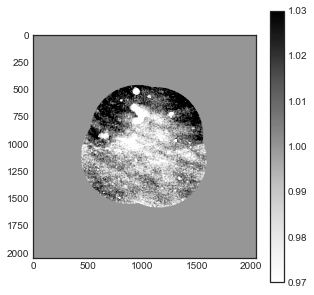

In [6]:
plt.imshow(gain,vmin=0.97,vmax=1.03)
plt.colorbar()
plt.show()